# Projecting Offshore Wind Costs with Learning Rates <br />
### Background <br />
Learning curves describe cost reductions associated with producing more of a <br />
particular good or service. They are observed empirically for any form of <br />
industrial production. We can derive learning curves to forecast future offshore <br />
wind energy project capital expenditure (CapEx) costs. To do this, we need 3 things: <br />

1. A learning rate - Learning rates describe the percentage cost reduction for every <br />
doubling of production (in this case global installed fixed-bottom offshore wind capacity) <br />
2. To calculate cost reductions over time, we need estimates of global offshore <br />
wind deployment over time (specified in MW) and projections for future years. <br />
3. Finally, we need a estimates of current offshore wind CapEx costs. <br />
#
This example works through how we obtain each item and combine them to estimate future costs. <br/>
For additional information, see "Technological Learning in the Transition to a Low-Carbon <br/>
Energy System" from Junginger and Louwen as well as Shields, Beiter, and Nunemaker (2022): <br/>
https://www.sciencedirect.com/book/9780128187623/technological-learning-in-the-transition-to-a-low-carbon-energy-system <br/>
https://www.nrel.gov/docs/fy23osti/81819.pdf <br />

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FORCE.learning import Regression
from FORCE.utils import plot_learning_forecast, calc_curve

C:\Users\pduffy\AppData\Local\Temp\1\ipykernel_28520\2029311084.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Junginger and Louwen (2020) describe the learning (experience) curve with the following equation: <br/>
$$
C_Q = C_1 * Q^b
$$
<br/>
where C_Q is the cost of the product at cumulative production Q, and C_1 is <br/>
the cost of the first unit (Q=1) produced, and b in the experience parameter. <br/>
<br/>


The experience parameter (b) can be related to the learning rate (LR) by: <br/>
<br/>
$$
LR = 1 - 2^b
$$
<br/>

In [2]:
def lr_from_b(b):
    lr = 1-2**b
    return lr

# 1. Use FORCE to obtain learning rates from a regression of historical data
We use 4C Offshore's Global Offshore Wind Farms database for the data used <br/>
in regression (historical fixed-bottom deployment and CapEx). Note that <br/>
this database requires a paid subscription, so we do not include the data, but <br/>
an example of the required format is available in /data/project_list_template.csv.

In [3]:
# Load Data
fp = os.path.join(os.getcwd(), "data", "2021_OWMR.csv") # Replace with path to your data
projects = pd.read_csv(fp, header=2) #, encoding="ISO-8859-1") # encoding may be required for databases that have project names with special characters

#### Define parameters for regresion
Note that including a variable in "_predictors" excludes its effects from the learning <br/>rate. Below we configure the regression to match the learning rates obtained in <br/>Shields, Beiter, and Nunemaker (2022).

In [4]:
# Define regression parameters
filters = {
   'Capacity MW (Max)': (149, ),
   'Full Commissioning': (2014, 2021),
}

to_aggregate = {
    'United Kingdom': 'United Kingdom',
    'Germany': 'Germany',
    'Netherlands': 'Netherlands',
    'Belgium' : 'Belgium',
    'China': 'China',
    'Denmark': 'Denmark',
}

to_drop = []

fixed_predictors = [
            'Country Name',
            'Water Depth Max (m)',
            'Capacity MW (Max)', # fixed is already commercial scale so we include this in the list to exclude effects from LR
            'Distance From Shore Auto (km)',
            ]
float_predictors = [
            'Country Name',
            'Water Depth Max (m)',
            'Distance From Shore Auto (km)',
            ]

In [5]:
# Define and run the regression
def run_regression(projects, filters, to_aggregate, to_drop, predictors):
    """
    Run FORCE Regression with given settings.

    Parameters
    ----------
    projects : DataFrame
    filters : dict
    to_aggregate : dict
    to_drop : list
        List of countries to drop.
    """

    regression = Regression(
        projects,
        y_var="log CAPEX_per_kw",
        filters=filters,
        regression_variables=predictors,
        aggregate_countries=to_aggregate,
        drop_categorical=["United Kingdom"],
        drop_country=to_drop,
        log_vars=['Cumulative Capacity', 'CAPEX_per_kw'],
    )
    print(regression.summary)
    return regression

#### Run regression to obtain fixed-bottom offshore wind CapEx learning rate
The regression yields the experience factor "b" and the learning rate. <br/>
Shields, Beiter, and Nunemaker (2022) discuss how to interpret the regression output.

In [6]:
# Display regression results and learning rate
fixed_regression = run_regression(projects, filters, to_aggregate, to_drop, fixed_predictors)
print("Experience factor b: ", np.round(fixed_regression.cumulative_capacity_fit, 3))
print("Learning rate (%): ", np.round(fixed_regression.learning_rate * 100, 3))

                            OLS Regression Results                            
Dep. Variable:       log CAPEX_per_kw   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     26.68
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           2.14e-15
Time:                        16:34:42   Log-Likelihood:                 32.680
No. Observations:                  56   AIC:                            -45.36
Df Residuals:                      46   BIC:                            -25.11
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

We can estimate more and less aggressive ("Conservative" and "Advanced") learning rates <br/>based on the standard error obtained with the regression. This allows exploration <br/> of different scenarios for how deployment and costs evolve over time.

In [7]:
# Calculate experience factors and learning rates for "Conservative" and "Advanced" scenarios
b_fixed_conservative = fixed_regression.cumulative_capacity_fit + fixed_regression.cumulative_capacity_bse
b_fixed_advanced = fixed_regression.cumulative_capacity_fit - fixed_regression.cumulative_capacity_bse
print("Experience factor standard error bse: ", np.round(fixed_regression.cumulative_capacity_bse, 3))
print("Conservative learning rate (%):", np.round(lr_from_b(b_fixed_conservative)*100, 1))
print("Advanced learning rate (%): ", np.round(lr_from_b(b_fixed_advanced)*100, 1))

Experience factor standard error bse:  0.039
Conservative learning rate (%): 6.3
Advanced learning rate (%):  11.2


#### Repeat this process to obtain floating offshore wind CapEx learning rate


In [8]:
# Display regression results and learning rate
floating_regression = run_regression(projects, filters, to_aggregate, to_drop, float_predictors)
print("Experience factor b: ", np.round(floating_regression.cumulative_capacity_fit, 3))
print("Learning rate (%): ", np.round(floating_regression.learning_rate * 100, 1))


                            OLS Regression Results                            
Dep. Variable:       log CAPEX_per_kw   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     19.71
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           1.26e-12
Time:                        16:34:42   Log-Likelihood:                 22.696
No. Observations:                  56   AIC:                            -27.39
Df Residuals:                      47   BIC:                            -9.165
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [9]:
# Calculate experience factors and learning rates for "Conservative" and "Advanced" scenarios
b_floating_conservative = floating_regression.cumulative_capacity_fit + floating_regression.cumulative_capacity_bse
b_floating_advanced = floating_regression.cumulative_capacity_fit - floating_regression.cumulative_capacity_bse
print("Experience factor standard error bse: ", np.round(floating_regression.cumulative_capacity_bse, 3))
print("Conservative learning rate (%):", np.round(lr_from_b(b_floating_conservative)*100, 1))
print("Advanced learning rate (%): ", np.round(lr_from_b(b_floating_advanced)*100, 1))

Experience factor standard error bse:  0.045
Conservative learning rate (%): 8.7
Advanced learning rate (%):  14.2


# 2. Next, we need deployment projections.
We compile this data from a number of sources including NREL's Offshore Wind Market Report, <br/>Bloomberg New Energy Finance, 4C Offshore, Wood Mackenzie, Aegir Insights, and others. <br/> Note that the projections included are out-of-date, but this example seeks to replicate the cost <br/>projections detailed by Shields, Beiter, and Nunemaker (2022). Since deployment trajectories are<br/> not monotonically decreasing, the learning curves will not either. <br/> This can be resolved by assuming a linear deployment trajectory.

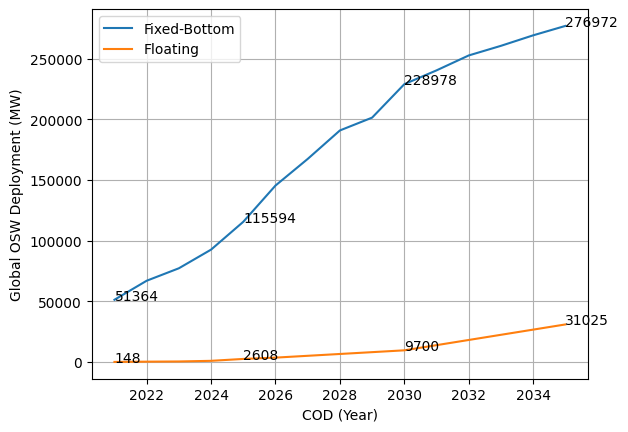

In [10]:
# Taking deployment trajectory from average of projections from multiple sources (should be refined)
fixed_forecast = pd.read_csv("data/2021_fixed_forecast.csv") # data in MW
floating_forecast = pd.read_csv("data/2021_floating_forecast.csv") # data in MW


interest_years = [2021,2025,2030,2035]

plt.figure()
plt.plot(fixed_forecast["year"],fixed_forecast["capacity"], label="Fixed-Bottom")
plt.plot(floating_forecast["year"], floating_forecast["capacity"], label="Floating")
for yr in interest_years:
    fb_q = fixed_forecast["capacity"][yr-2021]
    fl_q = floating_forecast["capacity"][yr-2021]
    plt.annotate(round(fb_q),(yr,fb_q))
    plt.annotate(round(fl_q),(yr,fl_q))
plt.xlabel("COD (Year)")
plt.ylabel("Global OSW Deployment (MW)")
plt.grid()
plt.legend()
plt.show()

# 3. Last, we need current offshore wind CapEx estimates.
Shields, Beiter, and Nunemaker (2022) use bottom up models to estimate 2021 fixed and floating CapEx at $3,186/kW and $9,924/kW, respectively.

# Now we can derive learning curves from learning rates and deployment projections.

To calculate percent cost reduction (r) relative to present cost <br/> (C_p), present deployment (Q_p), future deployment (Q_f), and b: <br/>

$$
r = \frac{C_p - C_f}{C_p} = 1 - (\frac{Q_f}{Q_p})^b
$$

This is the same as: <br/>
$$
r = 1 - (1 - LR)^N
$$
<br/>
where N is the number of doublings in deployment.

$$
N = Log_2(\frac{Q_f}{Q_p})

In [11]:
def calc_reduction(b,Q):
    """Percent CapEx Reduction"""
    r = 1 - (Q["capacity"]/Q["capacity"][0]) ** b
    return r*100


#### Fixed-bottom CapEx reduction

In [12]:
# Compute percent reductions for different scenarios
r_fixed = calc_reduction(fixed_regression.cumulative_capacity_fit,fixed_forecast)
r_fixed_conservative = calc_reduction(b_fixed_conservative,fixed_forecast)
r_fixed_advanced = calc_reduction(b_fixed_advanced,fixed_forecast)

fixed_capex = 3186*(1-r_fixed/100) # use starting capex to estimate in dollar terms
fixed_capex_conservative = 3186*(1-r_fixed_conservative/100)
fixed_capex_advanced = 3186*(1-r_fixed_advanced/100)

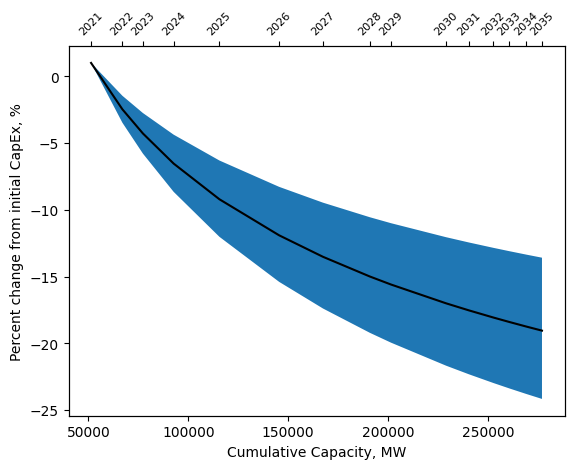

In [13]:
# Plot percent CapEx reduction over time (and deployment)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fixed_forecast["capacity"], 1-r_fixed, "k-")
ax1.fill_between(fixed_forecast["capacity"], 1-r_fixed_advanced, 1-r_fixed_conservative)
ax1.set_xlabel("Cumulative Capacity, MW")
ax1.set_ylabel("Percent change from initial CapEx, %")

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(fixed_forecast["capacity"])
ax2.set_xticklabels(fixed_forecast["year"], rotation=45, fontsize=8)
ax2.set_ylabel("Projected COD")
plt.show()

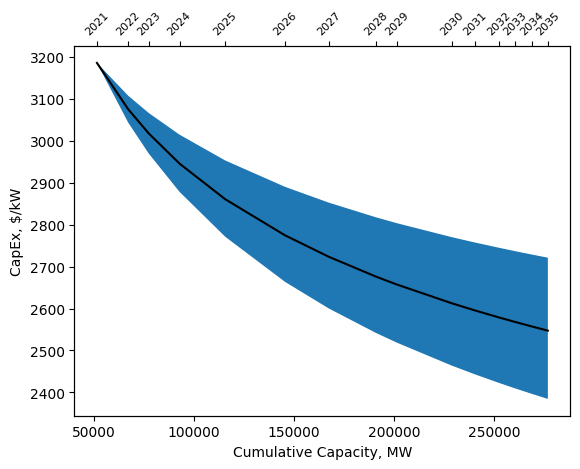

In [14]:
# Plot CapEx over time (and deployment)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fixed_forecast["capacity"], fixed_capex, "k-")
ax1.fill_between(fixed_forecast["capacity"], fixed_capex_advanced, fixed_capex_conservative)
ax1.set_xlabel("Cumulative Capacity, MW")
ax1.set_ylabel("CapEx, $/kW")

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(fixed_forecast["capacity"])
ax2.set_xticklabels(fixed_forecast["year"], rotation=45, fontsize=8)
ax2.set_ylabel("Projected COD")
plt.show()

#### Floating CapEx reduction

In [15]:
# Compute percent reductions for different scenarios
r_floating = calc_reduction(floating_regression.cumulative_capacity_fit,floating_forecast)
r_floating_conservative = calc_reduction(b_floating_conservative,floating_forecast)
r_floating_advanced = calc_reduction(b_floating_advanced,floating_forecast)

floating_capex = 9924*(1-r_floating/100)
floating_capex_conservative = 9924*(1-r_floating_conservative/100)
floating_capex_advanced = 9924*(1-r_floating_advanced/100)

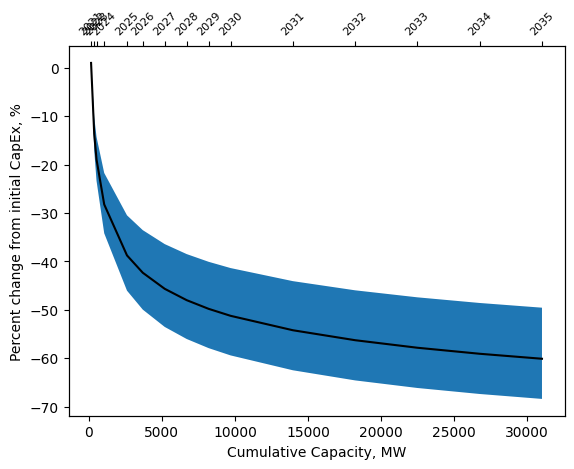

In [16]:
# Plot percent CapEx reduction over time (and deployment)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(floating_forecast["capacity"], 1-r_floating, "k-")
ax1.fill_between(floating_forecast["capacity"], 1-r_floating_advanced, 1-r_floating_conservative)
ax1.set_xlabel("Cumulative Capacity, MW")
ax1.set_ylabel("Percent change from initial CapEx, %")

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(floating_forecast["capacity"])
ax2.set_xticklabels(floating_forecast["year"], rotation=45, fontsize=8)
ax2.set_ylabel("Projected COD")
plt.show()

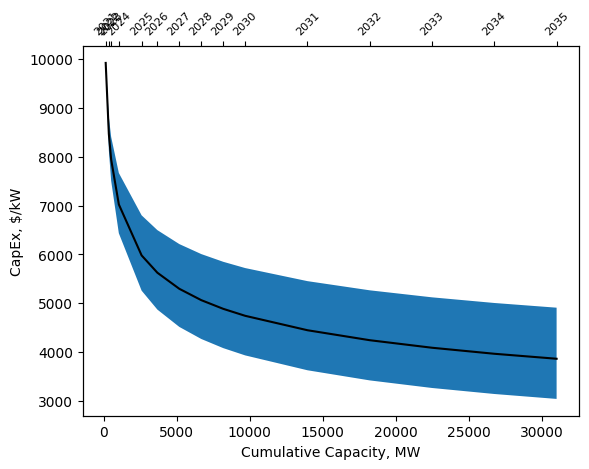

In [17]:
# Plot CapEx over time (and deployment)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(floating_forecast["capacity"], floating_capex, "k-")
ax1.fill_between(floating_forecast["capacity"], floating_capex_advanced, floating_capex_conservative)
ax1.set_xlabel("Cumulative Capacity, MW")
ax1.set_ylabel("CapEx, $/kW")

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(floating_forecast["capacity"])
ax2.set_xticklabels(floating_forecast["year"], rotation=45, fontsize=8)
ax2.set_ylabel("Projected COD")
plt.show()